In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import math
from sklearn import metrics as m

warnings.filterwarnings("ignore")

Read the data
===========

In [2]:
# x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
# y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

# x_original=x_original[['Unnamed: 0','L100800', 'L104600', 'S000300', 'SEX', 'S000501', 'L101700',
#        'L190400', 'S000502', 'L190500', 'L101300', 'AGE', 'FIELD_38',
#        'FIELD_31', 'FIELD_41'
#                       ]]

# y_original=y_original[['Unnamed: 0','L100800' ]]


# print(x_original.shape)
# print(y_original.shape)

In [3]:
# for index,col in enumerate(x_original.columns):
#     print(col,x_original[col].dropna().shape[0])

Prepare the data
============

In [4]:
data = pd.read_csv("../../sep19SexAndAgeAddedFINAL DATASET_ver2.txt", sep=",")
data["max"] = np.min(data[["FIELD_6", "FIELD_7"]], axis=1)
data = data.drop(columns=["FIELD_6", "FIELD_7"])

In [5]:


# change field 38 to 3 group
condtion = [
    data.FIELD_38 == 0,
    (data.FIELD_38 > 0) & (data.FIELD_38 < 4),
    data.FIELD_38 >= 4,
]
choice = [0, 1, 2]
data["FIELD_38_C"] = np.select(condtion, choice, default=np.nan)

data = data[
    [
        "L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000",
        "S000501",
    ]
]
data = data.dropna().reset_index()

# data=data[data.FIELD_15==0]
# data=data[data.FIELD_22==0]
# data=data[data.SEX==0]
# data=data[data.AGE < 40]

# data = data.sample(100000, random_seed=42)

print(data.shape)

(461862, 17)


In [6]:
print(data.shape)
print(data.columns)
data.head()

(461862, 17)
Index(['index', 'L190300', 'FIELD_29', 'S000300', 'FIELD_38', 'AGE', 'SEX',
       'L100700', 'L100800', 'FIELD_33', 'FIELD_41', 'FIELD_42', 'L190500',
       'L101600', 'L103100', 'L103000', 'S000501'],
      dtype='object')


,index,L190300,FIELD_29,S000300,FIELD_38,AGE,SEX,L100700,L100800,FIELD_33,FIELD_41,FIELD_42,L190500,L101600,L103100,L103000,S000501
0,0,3.76,0.0,22.6,2.0,46.0,0.0,2.6,111.0,2.0,7.0,7.0,35.4,48.0,73.0,70.0,130.0
1,1,4.02,0.0,22.9,2.0,47.0,0.0,3.7,103.0,2.0,4.0,5.0,38.2,49.0,79.0,50.0,132.0
2,2,4.24,0.0,24.3,3.0,48.0,0.0,2.6,113.0,2.0,3.0,3.0,40.7,42.0,65.0,75.0,132.0
3,3,4.28,0.0,24.3,2.0,49.0,0.0,2.0,105.0,2.0,0.0,0.0,41.1,53.0,62.0,130.0,140.0
4,4,4.34,0.0,23.7,3.0,50.0,0.0,2.8,118.0,2.0,2.0,2.0,40.4,49.0,61.0,92.0,145.0


In [7]:
test = pd.read_csv("test.txt")
testpd = data[data.index.isin(list(test[["Unnamed: 0"]].values.astype(int).ravel()))]

train = pd.read_csv("train.txt")
trainpd = data[
    data.index.isin(list(train[["Unnamed: 0"]].values.astype(int).ravel()))
]

# list(xtest[["Unnamed: 0"]].values.astype(int).ravel())


In [8]:
x = data[
    [
        "L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000",
    ]
]

y = data[["S000501"]]

In [9]:
from keras.layers import Layer
from keras import backend as K


class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(int(input_shape[1]), self.units),
            initializer="uniform",
            trainable=True,
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Using TensorFlow backend.


Apply PCA
===========

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x)
# print(x.shape)

feature scaling
=======

In [ ]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# K = range(1, 20)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(
#         sum(np.min(cdist(x, kmeanModel.cluster_centers_, "euclidean"), axis=1))
#         / x.shape[0]
#     )
#     print(k)

# # Plot the elbow
# plt.plot(K, distortions, "bx-")
# plt.xlabel("k")
# plt.ylabel("Distortion")
# plt.title("The Elbow Method showing the optimal k")
# plt.show()

In [ ]:
# kmeanModel = KMeans(n_clusters=10).fit(x)
# x["lbl"] = kmeanModel.labels_

Random Forest Regressor
=============

In [ ]:
# ylable = y[["S000501"]]
# xtrain, xtest, ytrain, ytest = train_test_split(
#     x, ylable, random_state=42, test_size=0.3
# )

In [15]:
xtrain= trainpd[["L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000"]]
ytrain=trainpd[["S000501"]] 

xtest=testpd[["L190300",
        "FIELD_29",
        "S000300",
        "FIELD_38",
        "AGE",
        "SEX",
        "L100700",
        "L100800",
        "FIELD_33",
        "FIELD_41",
        "FIELD_42",
        "L190500",
        "L101600",
        "L103100",
        "L103000"]]
ytest= testpd[["S000501"]] 

In [16]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, random_state=0, verbose=0, n_estimators=100)
regr.fit(xtrain, ytrain)
print(regr.feature_importances_)
ypred = regr.predict(xtest)

[0.02989358 0.0058907  0.57244191 0.00753184 0.11552945 0.09959675
 0.00921369 0.07082721 0.00170085 0.00223894 0.00156094 0.04204215
 0.00982076 0.00862578 0.02308544]


mean_squared_error 113.54549870912395
root mean_squared_error 10.655773022597842
mean_absolute_error 8.499023665746101
r2_score 0.2894403680493829


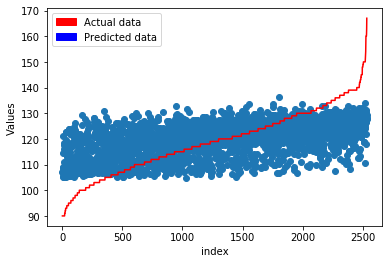

,t + 1,pred (t +1)
1855,154.0,131.251209
1724,158.0,127.754280
2085,160.0,121.869040
1492,160.0,129.761209
1069,160.0,126.467216
994,160.0,118.041940
2485,160.0,126.396291
558,161.0,129.207328
751,163.0,127.860936
639,167.0,128.156862


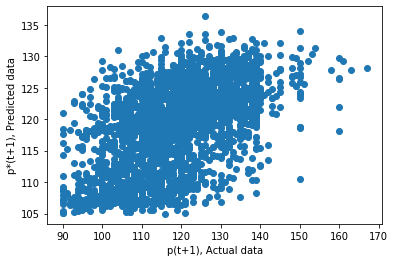

In [17]:
print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(30)

import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.tail(10)

In [18]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

< 5  35.488958990536275
< 10  65.41798107255521
< 15  84.38485804416403
< 20  94.20347003154573
< 25  97.94952681388013
< 30  99.40851735015772


In [37]:
xtest.to_csv("xtest.txt", sep=",")
ytest.to_csv("ytest.txt", sep=",")

xtrain.to_csv("xtrain.txt", sep=",")
ytrain.to_csv("ytrain.txt", sep=",")

pd.DataFrame(ypred,ytest.index.ravel()).to_csv("ypred_s000501.txt", sep=",")

In [39]:
ytest.shape

(2536, 1)

xg boost
==========

In [20]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective="reg:squarederror")
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [21]:
ypred = xg_reg.predict(xtest)

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(10)

mean_squared_error 111.33963436707889
root mean_squared_error 10.55175977584208
mean_absolute_error 8.407009359413893
r2_score 0.30324450976205275


,t + 1,pred (t +1)
0,120.0,110.099174
1,139.0,114.408539
2,117.0,109.802010
3,126.0,127.790520
4,105.0,109.135559
5,118.0,123.398865
6,110.0,115.639503
7,116.0,122.375198
8,114.0,113.167389
9,113.0,119.484703


In [22]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

< 5  37.06624605678233
< 10  66.00946372239747
< 15  84.58201892744479
< 20  94.4794952681388
< 25  97.98895899053628
< 30  99.48738170347004


In [23]:
xtest.to_csv("xtest.txt", sep=",")
ytest.to_csv("ytest.txt", sep=",")

xtrain.to_csv("xtrain.txt", sep=",")
ytrain.to_csv("ytrain.txt", sep=",")

pd.DataFrame(ypred).to_csv("ypred_s000501.txt", sep=",")

ANN
==========

In [ ]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
model = Sequential()
model.add(
    Dense(input_dim=16, units=512, activation="relu", kernel_initializer="uniform")
)
model.add(Dense(units=512, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(512, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# model.add(Dense(units=256, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(256, 0.5))
# model.add(Dense(units=256, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(256, 0.5))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(units=128, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(128, 0.5))
model.add(Dense(units=128, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(128, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# model.add(Dense(units=64, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(64, 0.5))
# model.add(Dense(units=64, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(64, 0.5))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

model.add(Dense(units=32, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(32, 0.5))
model.add(Dense(units=32, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(32, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(units=16, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(16, 0.5))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=8, activation="relu", kernel_initializer="uniform"))
# model.add(RBFLayer(8, 0.5))

model.add(Dense(units=1, kernel_initializer="uniform"))
model.compile(
    loss="mean_squared_error", optimizer="Nadam", metrics=["mean_squared_error"]
)

In [ ]:
h = model.fit(xtrain, ytrain, validation_split=0.2, epochs=100, batch_size=10000)

In [ ]:
ypred = model.predict(xtest)

import math

print("mean_squared_error", m.mean_squared_error(ytest, ypred))
print("root mean_squared_error", math.sqrt(m.mean_squared_error(ytest, ypred)))
print("mean_absolute_error", m.mean_absolute_error(ytest, ypred))
print("r2_score", m.r2_score(ytest, ypred))

ypredPD = pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD["t + 1"] = ytest.values.ravel()
ypredPD["pred (t +1)"] = ypred
ypredPD.head(10)

In [ ]:
history = h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["val_mean_squared_error"])
plt.plot(history.history["mean_squared_error"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print(np.mean(ypredPD["diff"]))
print(np.std(ypredPD["diff"]))
print(100 * ypredPD[ypredPD["diff"] <= 5].shape[0] / ypredPD.shape[0])

In [ ]:
import matplotlib.patches as mpatches

plt.ylabel("Values")
plt.xlabel("index")
red_patch = mpatches.Patch(color="red", label="Actual data")
blue_patch = mpatches.Patch(color="blue", label="Predicted data")
plt.legend(handles=[red_patch, blue_patch])

ypredPD = ypredPD.sort_values(by=["t + 1"])
plt.scatter(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)
plt.plot(
    np.arange(0, ypredPD.shape[0], 1), ypredPD["t + 1"][: ypredPD.shape[0]], color="red"
)
plt.show()

plt.ylabel("p*(t+1), Predicted data")
plt.xlabel("p(t+1), Actual data")
plt.scatter(
    ypredPD["t + 1"][: ypredPD.shape[0]], ypredPD["pred (t +1)"][: ypredPD.shape[0]]
)

ypredPD.head(10)

In [ ]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("< 5 ", 100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0])
print("< 10 ", 100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0])
print("< 15 ", 100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0])
print("< 20 ", 100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0])
print("< 25 ", 100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0])
print("< 30 ", 100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0])

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
from keras.layers import Layer
from keras import backend as K


class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name="mu",
            shape=(int(input_shape[1]), self.units),
            initializer="uniform",
            trainable=True,
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)